# ALeRCE API interaction examples

Load libraries

In [21]:
import sys
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

In [22]:
#!pip install alerce
from alerce.api import AlerceAPI

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20ZTF%20DB%20API.md

In [23]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialize alerce api object

In [24]:
alerce = AlerceAPI()

# 1. query

Query a list of objects

The following json file should be sent

```js
{
total: number, // (if not set the total is counted and the query is slower),
records_per_pages: number. // default 20
page: number (default 1),
sortBy: string columnName, // default nobs
query_parameters:{
    filters:{
        //ZTF Object id
        oid: "ZTFXXXXXX",
        //Number of detections
        nobs: { 
            min: int
            max: int
        },
        //Late Classifier (Random Forest)
        classrf: ["CEPH","DSCT","EB","LPV","RRL","SNe","Other"] or int,
        pclassrf: float [0-1],
        //Early Classifier (Stamp Classifier)
        classearly: ["AGN","SN","VS","asteroid","bogus"] or int,
        pclassearly: float [0-1],
    },
    //Coordinate based search (RA,DEC) and Search Radius.
    coordinates:{
        ra: float degrees,
        dec: float degrees,
        sr: float degrees
    },
    dates:{
        //First detection (Discovery date)
        firstmjd: {
         min: float mjd,
         max: float mjd
        }
    }
}
```

### Example: 

Give me all the objects with probability of being SNe greater than 0.8 according to the random forest classifier (light curve based), which have between 2 and 40 detections. Give me the second page, with pages of 10 elements each, of a total of at most 40 objects query result.

Note: probabilities are experimental and should not be fully trusted

In [25]:
total = 40
records_per_page = 10
page = 2
sortBy = "firstmjd"
nobsmin = 10
nobsmax = 40
classrf = "SNe"
pclassrf = 0.8

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": { 
                "min": nobsmin,
                "max": nobsmax
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [26]:
query_results = alerce.query(params)
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abnishu,None,None,6,None,36.957639,20.130600,19.237801,20.253887,19.292255,58699.478160,...,19,NaN,0.818,None,0.566951,0.310869,0.574562,0.318788,0.000014,0.000014
ZTF19abnxcee,None,AGN,6,None,6.943495,19.160569,19.639609,19.238099,19.752392,58701.300741,...,13,0.600848,0.830,None,0.356427,0.467078,0.276728,0.478794,0.000013,0.000019
ZTF19abnxyow,None,SN,6,None,12.029583,20.084200,18.481501,19.582569,18.149042,58703.290833,...,14,0.587974,0.806,None,0.501771,0.583132,0.441592,0.466312,0.000016,0.000023
ZTF19abopyyu,None,SN,6,None,33.019352,19.221001,20.667900,19.319675,20.449636,58703.442153,...,19,0.970260,0.858,None,0.373502,0.761683,0.403206,0.677309,0.000020,0.000025
ZTF19abpfxfs,None,None,6,None,25.999086,20.428499,19.853399,20.169247,19.952568,58706.475035,...,13,NaN,0.800,None,0.626482,0.455032,0.507034,0.470698,0.000029,0.000021


### Example: 

Give me the last 100 objects with classified as SNe according to the early classifier (one image stamp)

Note: this is experimental, about 90% of the candidates are false positives

In [27]:
mjd_48hr = Time(datetime.utcnow(), scale='utc').mjd - 2.

total = 100
records_per_page = 100
sortBy = "pclassearly"

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "classearly": 2
        },
        "dates": {
            "firstmjd": {
                "min": mjd_48hr
            }
        }
    }
}

In [28]:
query_results = alerce.query(params)
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aacsudg,None,SN,None,None,0.0,NaN,18.2237,NaN,18.165924,58736.509236,...,1,1.000000,None,None,None,None,None,None,NaN,NaN
ZTF18aaffhxn,None,SN,None,None,0.0,19.372101,NaN,19.345505,NaN,58736.493044,...,1,0.999999,None,None,None,None,None,None,NaN,NaN
ZTF18aakybtr,None,SN,None,None,0.0,NaN,19.0390,NaN,18.927469,58736.272060,...,1,0.997790,None,None,None,None,None,None,NaN,NaN
ZTF18aarunws,None,SN,None,None,0.0,19.328899,NaN,19.343952,NaN,58735.133588,...,1,0.997445,None,None,None,None,None,None,NaN,NaN
ZTF18abhpwpf,None,SN,None,None,0.0,20.863001,NaN,20.525160,NaN,58735.431424,...,1,0.997493,None,None,None,None,None,None,NaN,NaN


(21.06023812725213, 14.515577587294672)

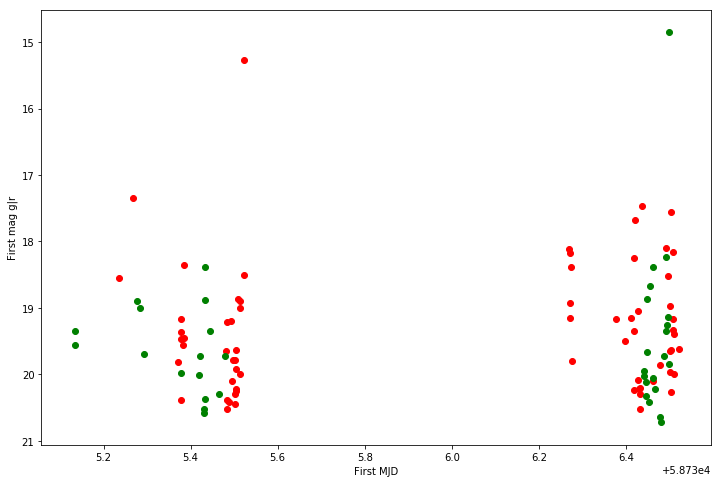

In [29]:
# Show first mag vs first MJD
fig, ax = plt.subplots(figsize = (12, 8))
mask = query_results.first_magpsf_r.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_r[mask], c = 'r')
mask = query_results.first_magpsf_g.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_g[mask], c = 'g')
ax.set_xlabel("First MJD")
ax.set_ylabel("First mag g|r")
ax.set_ylim(ax.get_ylim()[::-1])

You can see the ZTF filter changes during the night. The missing times are due to the ZTF private stream.

# 2. get_sql

Get the sql query using the same parameters as the previous query

In [30]:
alerce.get_sql(params)

b"SELECT * FROM objects WHERE  classearly = 'SN' AND  firstmjd >= 58734.579586484 "

# 3. get_detections

Get all the detections for an object

In [31]:
oid = "ZTF19aaxqsbn"

In [32]:
detections = alerce.get_detections(oid)
display(detections.head())
list(detections)

,candid_str,dec,diffmaglim,distpsnr1,fid,field,isdiffpos,magap,magap_corr,magnr,...,rb,rcid,sgscore1,sigmadec,sigmagap,sigmagap_corr,sigmagnr,sigmapsf,sigmapsf_corr,sigmara
candid,,,,,,,,,,,,,,,,,,,,,
886240045615015003,886240045615015003,80.162942,20.342619,1.676753,2,862,1,19.145700,19.145700,16.899,...,0.944286,56,0.196298,0.09,0.1670,0.1670,0.073,0.111001,0.111001,0.09
889199085615015000,889199085615015000,80.162995,20.061783,1.792658,1,862,1,19.063999,19.063999,17.948,...,0.750000,56,0.196298,0.09,0.1374,0.1374,0.062,0.153750,0.153750,0.09
889249055615015001,889249055615015001,80.162994,20.234301,1.745674,2,862,1,18.581699,18.581699,16.899,...,0.947143,56,0.196298,0.09,0.1058,0.1058,0.073,0.085079,0.085079,0.09
892240745615015005,892240745615015005,80.162949,19.379860,1.706684,2,862,1,18.940800,18.940800,16.899,...,0.892857,56,0.196298,0.09,0.2974,0.2974,0.073,0.104200,0.104200,0.09
895195845615015003,895195845615015003,80.162940,19.375284,1.912989,1,862,1,18.676800,18.676800,17.948,...,0.951429,56,0.196298,0.09,0.1865,0.1865,0.062,0.112041,0.112041,0.09


['candid_str',
 'dec',
 'diffmaglim',
 'distpsnr1',
 'fid',
 'field',
 'isdiffpos',
 'magap',
 'magap_corr',
 'magnr',
 'magpsf',
 'magpsf_corr',
 'mjd',
 'object_id',
 'oid',
 'ra',
 'rb',
 'rcid',
 'sgscore1',
 'sigmadec',
 'sigmagap',
 'sigmagap_corr',
 'sigmagnr',
 'sigmapsf',
 'sigmapsf_corr',
 'sigmara']

# 4. get_non_detections

In [33]:
non_detections = alerce.get_non_detections(oid)
non_detections.head()

,diffmaglim,fid,object_id,oid
mjd,,,,
58617.203958,19.953899,1,None,ZTF19aaxqsbn
58617.203958,19.953899,1,None,ZTF19aaxqsbn
58617.203958,19.953899,1,None,ZTF19aaxqsbn
58617.203958,19.953899,1,None,ZTF19aaxqsbn
58617.297940,19.972601,2,None,ZTF19aaxqsbn


(20.85893068626529, 15.77118088180006)

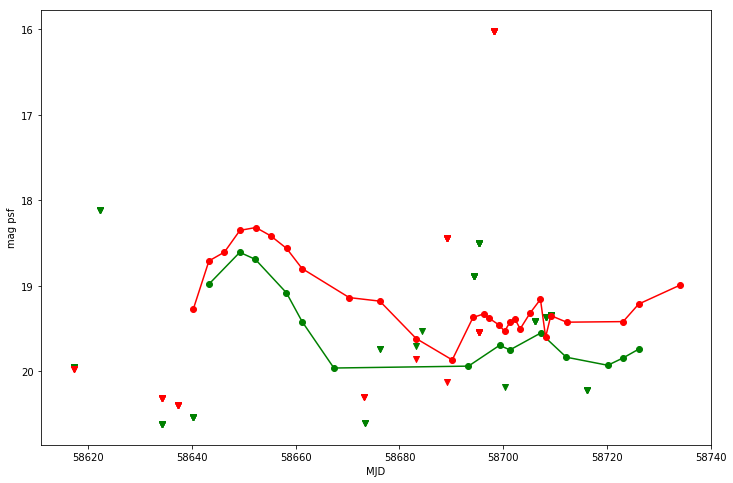

In [34]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = ["g", "r"]
for fid in [1, 2]:
    mask = detections.fid == fid
    ax.plot(detections.mjd[mask], detections.magpsf[mask], c = colors[fid - 1], marker = "o")
    mask = non_detections.fid == fid
    # note that the index of non-detectionsis the mjd
    ax.scatter(non_detections.index[mask], non_detections.diffmaglim[mask], c = colors[fid - 1], marker = "v")
ax.set_xlabel("MJD")
ax.set_ylabel("mag psf")
ax.set_ylim(ax.get_ylim()[::-1])

# 5. get_stats

In [35]:
stats = alerce.get_stats(oid)
display(stats)
list(stats)

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aaxqsbn,None,SN,6,None,93.891551,19.063999,19.1457,18.982498,19.270462,58640.240046,...,42,0.999165,0.67,None,0.509753,0.4669,0.470786,0.415023,0.000044,0.000241


['catalogid',
 'classearly',
 'classrf',
 'classxmatch',
 'deltajd',
 'first_magap_g',
 'first_magap_r',
 'first_magpsf_g',
 'first_magpsf_r',
 'firstmjd',
 'last_magap_g',
 'last_magap_r',
 'last_magpsf_g',
 'last_magpsf_r',
 'lastmjd',
 'max_magap_g',
 'max_magap_r',
 'max_magpsf_g',
 'max_magpsf_r',
 'mean_magap_g',
 'mean_magap_r',
 'mean_magpsf_g',
 'mean_magpsf_r',
 'meandec',
 'meanra',
 'median_magap_g',
 'median_magap_r',
 'median_magpsf_g',
 'median_magpsf_r',
 'min_magap_g',
 'min_magap_r',
 'min_magpsf_g',
 'min_magpsf_r',
 'nobs',
 'pclassearly',
 'pclassrf',
 'period',
 'sigma_magap_g',
 'sigma_magap_r',
 'sigma_magpsf_g',
 'sigma_magpsf_r',
 'sigmadec',
 'sigmara']

# 6. get_probabilities

In [36]:
probs = alerce.get_probabilities(oid)
display(probs["early"])
display(probs["late"])

,agn_prob,asteroid_prob,bogus_prob,classifier_version,sn_prob,vs_prob
oid,,,,,,
ZTF19aaxqsbn,0.000005,5.469358e-09,0.000829,None,0.999165,4.666816e-10


,ceph_prob,classifierid,dsct_prob,eb_prob,lpv_prob,object_id,other_prob,rrl_prob,sne_prob
oid,,,,,,,,,
ZTF19aaxqsbn,0.026,1,0.01,0.014,0.072,None,0.14,0.068,0.67


# 7. get_features

In [37]:
features = alerce.get_features(oid)
features

,result.period.n_samples_1,result.period.n_samples_2,result.period.periodls_1,result.period.periodls_2
oid,,,,
ZTF19aaxqsbn,14.0,28.0,0.988142,0.988142


# 8. get_stamp

Get the stamps of an object.

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20AVRO-STAMP%20Access%20API.md

In [38]:
# note that the index of detections is the candid
print(oid)
alerce.plot_stamp(oid)
alerce.plot_stamp(oid, detections.index.min())
alerce.plot_stamp(oid, detections.index.max())

ZTF19aaxqsbn
